<a href="https://colab.research.google.com/github/h0806449f/PyTorch/blob/main/DB_09_model_deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **== Functions and setups ==**

## Setups

In [4]:
!pip install torchinfo

In [5]:
import os
import requests
import zipfile
import pathlib
import random
import numpy as np
import pandas as pd
from pathlib import Path
from typing import List, Dict
from PIL import Image


import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from timeit import default_timer as timer


import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchinfo import summary

## Functions

In [6]:
# train -> train_loss, train_acc
def train(model, dataloader, loss_fn, optimizer, device):
    model.to(device)
    model.train()

    train_loss, train_acc = 0, 0

    for batch, (X_train, y_train) in enumerate(dataloader):
        X_train, y_train = X_train.to(device), y_train.to(device)

        train_preds = model(X_train)

        loss = loss_fn(train_preds, y_train)
        train_loss = train_loss + loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_preds_label = torch.argmax(torch.softmax(train_preds, dim = 1), dim = 1)
        train_acc = train_acc + (train_preds_label == y_train).sum().item() / len(train_preds)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc

In [7]:
# test -> test_loss, test_acc
def test(model, dataloader, loss_fn, device):
    model.to(device)
    model.eval()

    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X_test, y_test) in enumerate(dataloader):
            X_test, y_test = X_test.to(device), y_test.to(device)

            test_preds = model(X_test)

            loss = loss_fn(test_preds, y_test)
            test_loss = test_loss + loss.item()

            test_preds_label = torch.argmax(torch.softmax(test_preds, dim = 1), dim = 1)
            test_acc = test_acc + (test_preds_label == y_test).sum().item() / len(test_preds)

        test_loss = test_loss / len(dataloader)
        test_acc = test_acc / len(dataloader)

        return test_loss, test_acc

In [8]:
# train_test_loop -> results dictionary
def train_test_loop(model, train_dataloader, test_dataloader, loss_fn, optimizer, epochs, device):
    results = {"train_loss":[], "train_acc":[], "test_loss":[], "test_acc":[]}

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train(model = model, dataloader = train_dataloader, loss_fn = loss_fn, optimizer = optimizer, device = device)
        test_loss, test_acc = test(model = model, dataloader = test_dataloader, loss_fn = loss_fn, device = device)

        print(f"Epoch: {epoch+1}\n"
              f"Train Loss: {train_loss:.4f} | Train Accuracy: {(train_acc*100):.2f}%\n"
              f"Test Loss: {test_loss:.4f} | Test Accuracy: {(test_acc*100):.2f}%")

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

    # plt.figure(figsize = (6, 3))
    # plt.subplot(1, 2, 1)
    # plt.plot(results["train_loss"], label = "Train Loss")
    # plt.plot(results["test_loss"], label = "Test Loss")
    # plt.subplot(1, 2, 2)
    # plt.plot(results["train_acc"], label = "Train Accuracy")
    # plt.plot(results["test_acc"], label = "Test Accuracy")

In [9]:
# Create a function -> make prediction across test dataset
def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu"
                   ) -> List[Dict]:
    # 空字典, 儲存 train_test_loop 的 dict
    pred_list = []

    # Loop through target path
    for path in tqdm(paths):

        # 空字典, 儲存預測結果
        pred_dict = {}

        # 檔案名稱, 檔案類別
        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name

        # Time
        start_time = timer()

        # Open image path
        img = Image.open(path)

        # Transform image, add batch size, to device
        transformed_image = transform(img).unsqueeze(dim = 0).to(device)

        # model
        model.to(device)
        model.eval()

        # Get probs, label, class names
        with torch.inference_mode():
            preds_logits = model(transformed_image)
            preds_probs = torch.softmax(preds_logits, dim = 1)
            preds_label = torch.argmax(preds_probs, dim = 1)
            # Hard code prds_label to cpu
            preds_class = class_names[preds_label.cpu()]

            # 將結果放到 cpu 上, for numpy
            pred_dict["preds_prob"] = round(preds_probs.unsqueeze(0).max().cpu().item(), 4)
            pred_dict["pred_class"] = preds_class

            # End the timer
            end_time = timer()
            pred_dict["time_for_predict"] = round(end_time - start_time, 4)

        # 正確與否
        pred_dict["correct"] = class_name == preds_class

        #
        pred_list.append(pred_dict)

    return pred_list

# **== Dataset and dataloader ==**

## Raw data

In [10]:
data_dir = Path("data/")
image_dir = data_dir / "pizza_steak_sushi"

if image_dir.is_dir():
    print(f"[INFO] {image_dir} already exists")
else:
    image_dir.mkdir(parents = True, exist_ok = True)
    print(f"[INFO] {image_dir} creating")

    with open(data_dir / "DB_image.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print(f"[INFO] zip file downloading")
        f.write(request.content)

    with zipfile.ZipFile(data_dir / "DB_image.zip", "r") as zip_f:
        print(f"[INFO] zip file unzipping")
        zip_f.extractall(image_dir)

    zip_file_path = data_dir / "DB_image.zip"
    if zip_file_path.exists():
        print(f"[INFO] zip file removing")
        os.remove(zip_file_path)

[INFO] data/pizza_steak_sushi creating
[INFO] zip file downloading
[INFO] zip file unzipping
[INFO] zip file removing


## Dataloader

In [11]:
# 目標比較: efficientnet VS vision transformer
train_dir = image_dir / "train"
test_dir = image_dir / "test"

# Weights
effnet_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
effnet_transforms = effnet_weights.transforms()

# Dataset
effnet_train_dataset = datasets.ImageFolder(root = train_dir, transform = effnet_transforms)
effnet_test_dataset = datasets.ImageFolder(root = test_dir, transform = effnet_transforms)

# Dataloader
effnet_train_dataloader = DataLoader(dataset = effnet_train_dataset, batch_size = 32, shuffle = True, drop_last = True)
effnet_test_dataloader = DataLoader(dataset = effnet_test_dataset, batch_size = 32, shuffle = False, drop_last = True)

In [12]:
# Weights
vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
vit_tranforms = vit_weights.transforms()

# Dataset
vit_train_dataset = datasets.ImageFolder(root = train_dir, transform = vit_tranforms)
vit_test_dataset = datasets.ImageFolder(root = test_dir, transform = vit_tranforms)

# Dataloader
vit_train_dataloader = DataLoader(dataset = vit_train_dataset, batch_size = 32, shuffle = True, drop_last = True)
vit_test_dataloader = DataLoader(dataset = vit_test_dataset, batch_size = 32, shuffle = False, drop_last = True)

# **== Model and train model ==**

## Effnet

In [13]:
effnet_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

effnet_model = torchvision.models.efficientnet_b2(weights = effnet_weights)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 190MB/s]


In [14]:
for param in effnet_model.parameters():
    param.requires_grad = False

In [15]:
effnet_model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p = 0.3),
    torch.nn.Linear(in_features = 1408, out_features = 128),
    torch.nn.ReLU(),
    torch.nn.Dropout(p = 0.3),
    torch.nn.Linear(in_features = 128, out_features = 3)
)

In [16]:
summary(effnet_model,
        input_size = (32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width = 18)

Layer (type:depth-idx)                                  Input Shape        Output Shape       Param #            Trainable
EfficientNet                                            [32, 3, 224, 224]  [32, 3]            --                 Partial
├─Sequential: 1-1                                       [32, 3, 224, 224]  [32, 1408, 7, 7]   --                 False
│    └─Conv2dNormActivation: 2-1                        [32, 3, 224, 224]  [32, 32, 112, 112] --                 False
│    │    └─Conv2d: 3-1                                 [32, 3, 224, 224]  [32, 32, 112, 112] (864)              False
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112] [32, 32, 112, 112] (64)               False
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112] [32, 32, 112, 112] --                 --
│    └─Sequential: 2-2                                  [32, 32, 112, 112] [32, 16, 112, 112] --                 False
│    │    └─MBConv: 3-4                      

## Vit

In [17]:
vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

vit_model = torchvision.models.vit_b_16(weights = vit_weights)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:06<00:00, 57.1MB/s]


In [18]:
for param in vit_model.parameters():
    param.requires_grad = False

In [19]:
vit_model.heads = torch.nn.Sequential(
    torch.nn.Linear(in_features=768, out_features=64),
    torch.nn.ReLU(),
    torch.nn.Dropout(p = 0.3),
    torch.nn.Linear(in_features = 64, out_features = 3),
)

In [20]:
summary(vit_model,
        input_size = (32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width = 18)

Layer (type:depth-idx)                        Input Shape        Output Shape       Param #            Trainable
VisionTransformer                             [32, 3, 224, 224]  [32, 3]            768                Partial
├─Conv2d: 1-1                                 [32, 3, 224, 224]  [32, 768, 14, 14]  (590,592)          False
├─Encoder: 1-2                                [32, 197, 768]     [32, 197, 768]     151,296            False
│    └─Dropout: 2-1                           [32, 197, 768]     [32, 197, 768]     --                 --
│    └─Sequential: 2-2                        [32, 197, 768]     [32, 197, 768]     --                 False
│    │    └─EncoderBlock: 3-1                 [32, 197, 768]     [32, 197, 768]     (7,087,872)        False
│    │    └─EncoderBlock: 3-2                 [32, 197, 768]     [32, 197, 768]     (7,087,872)        False
│    │    └─EncoderBlock: 3-3                 [32, 197, 768]     [32, 197, 768]     (7,087,872)        False
│    │    └─Enco

## Train

In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(effnet_model.parameters(),
                             lr = 0.001)

effnet_results = train_test_loop(
    model = effnet_model,
    train_dataloader = effnet_train_dataloader,
    test_dataloader = effnet_test_dataloader,
    loss_fn = loss_fn,
    optimizer = optimizer,
    epochs = 10,
    device = device
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Train Loss: 1.0033 | Train Accuracy: 55.80%
Test Loss: 0.8399 | Test Accuracy: 90.62%
Epoch: 2
Train Loss: 0.6717 | Train Accuracy: 87.50%
Test Loss: 0.5233 | Test Accuracy: 93.75%
Epoch: 3
Train Loss: 0.4156 | Train Accuracy: 93.30%
Test Loss: 0.3585 | Test Accuracy: 95.31%
Epoch: 4
Train Loss: 0.2525 | Train Accuracy: 96.43%
Test Loss: 0.2978 | Test Accuracy: 93.75%
Epoch: 5
Train Loss: 0.2667 | Train Accuracy: 93.75%
Test Loss: 0.2545 | Test Accuracy: 93.75%
Epoch: 6
Train Loss: 0.1769 | Train Accuracy: 95.09%
Test Loss: 0.2340 | Test Accuracy: 95.31%
Epoch: 7
Train Loss: 0.1535 | Train Accuracy: 95.54%
Test Loss: 0.2244 | Test Accuracy: 95.31%
Epoch: 8
Train Loss: 0.0771 | Train Accuracy: 99.55%
Test Loss: 0.2169 | Test Accuracy: 95.31%
Epoch: 9
Train Loss: 0.0922 | Train Accuracy: 98.66%
Test Loss: 0.2143 | Test Accuracy: 95.31%
Epoch: 10
Train Loss: 0.0997 | Train Accuracy: 97.32%
Test Loss: 0.2296 | Test Accuracy: 93.75%


In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vit_model.parameters(),
                             lr = 0.001)

vit_results = train_test_loop(
    model = vit_model,
    train_dataloader = vit_train_dataloader,
    test_dataloader = vit_test_dataloader,
    loss_fn = loss_fn,
    optimizer = optimizer,
    epochs = 10,
    device = device
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Train Loss: 0.7657 | Train Accuracy: 82.14%
Test Loss: 0.3770 | Test Accuracy: 92.19%
Epoch: 2
Train Loss: 0.2940 | Train Accuracy: 94.64%
Test Loss: 0.1783 | Test Accuracy: 95.31%
Epoch: 3
Train Loss: 0.1587 | Train Accuracy: 95.54%
Test Loss: 0.1523 | Test Accuracy: 92.19%
Epoch: 4
Train Loss: 0.0963 | Train Accuracy: 96.88%
Test Loss: 0.1471 | Test Accuracy: 95.31%
Epoch: 5
Train Loss: 0.0844 | Train Accuracy: 98.21%
Test Loss: 0.1556 | Test Accuracy: 95.31%
Epoch: 6
Train Loss: 0.0454 | Train Accuracy: 99.11%
Test Loss: 0.1711 | Test Accuracy: 95.31%
Epoch: 7
Train Loss: 0.0347 | Train Accuracy: 99.11%
Test Loss: 0.1799 | Test Accuracy: 93.75%
Epoch: 8
Train Loss: 0.0329 | Train Accuracy: 99.55%
Test Loss: 0.1790 | Test Accuracy: 93.75%
Epoch: 9
Train Loss: 0.0237 | Train Accuracy: 100.00%
Test Loss: 0.1754 | Test Accuracy: 93.75%
Epoch: 10
Train Loss: 0.0183 | Train Accuracy: 100.00%
Test Loss: 0.1764 | Test Accuracy: 95.31%


## Plot Loss and accuracy

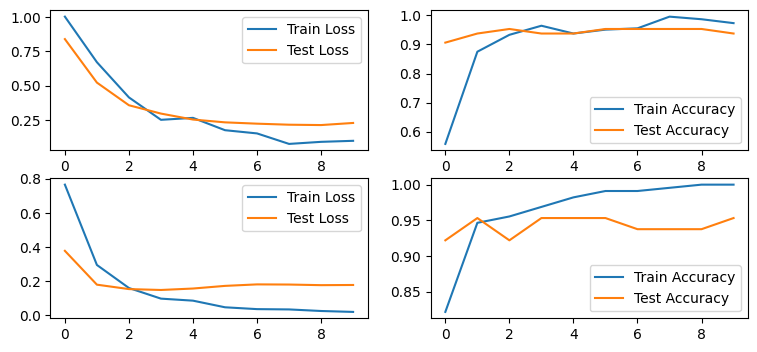

In [23]:
plt.figure(figsize = (9, 4))

plt.subplot(2, 2, 1)
plt.plot(effnet_results["train_loss"], label = "Train Loss")
plt.plot(effnet_results["test_loss"], label = "Test Loss")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(effnet_results["train_acc"], label = "Train Accuracy")
plt.plot(effnet_results["test_acc"], label = "Test Accuracy")
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(vit_results["train_loss"], label = "Train Loss")
plt.plot(vit_results["test_loss"], label = "Test Loss")
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(vit_results["train_acc"], label = "Train Accuracy")
plt.plot(vit_results["test_acc"], label = "Test Accuracy")
plt.legend()

# **== Save and check model's dize ==**

## Models path

In [24]:
models_path = Path("Models/")

if models_path.is_dir():
    print(f"[INFO] {models_path} already exist")
else:
    print(f"[INFO] {models_path} creating")
    models_path.mkdir(parents = True, exist_ok = True)

[INFO] Models creating


## Effnet size

In [25]:
torch.save(effnet_model, "Models/effnet.pt")

In [26]:
effnet_model_size = Path("Models/effnet.pt").stat().st_size // (1024*1024)
print(f"Model size: {effnet_model_size} MB")

Model size: 30 MB


## Vit size

In [27]:
torch.save(vit_model, "Models/vit.pt")

In [28]:
vit_model_size = Path("Models/vit.pt").stat().st_size // (1024*1024)
print(f"Model size: {vit_model_size} MB")

Model size: 327 MB


# **== Predict and calculate time ==**

## Test images' path

In [29]:
# Path
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

# Check
test_data_paths[:5]

[PosixPath('data/pizza_steak_sushi/test/steak/2117351.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/354513.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1627703.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/966174.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/296375.jpg')]

## Effnet

In [30]:
effnet_test_pred_list = pred_and_store(paths = test_data_paths,
                                       model = effnet_model,
                                       transform = effnet_transforms,
                                       class_names = ["pizza", "steak", "sushi"],
                                       device = "cpu") # make prediction on cpu

  0%|          | 0/75 [00:00<?, ?it/s]

In [31]:
# DF
effnetb2_df = pd.DataFrame(effnet_test_pred_list)

# Check
effnetb2_df.head()

,image_path,class_name,preds_prob,pred_class,time_for_predict,correct
0,data/pizza_steak_sushi/test/steak/2117351.jpg,steak,0.9900,steak,0.1948,True
1,data/pizza_steak_sushi/test/steak/354513.jpg,steak,0.3637,pizza,0.1074,False
2,data/pizza_steak_sushi/test/steak/1627703.jpg,steak,0.6125,steak,0.0988,True
3,data/pizza_steak_sushi/test/steak/966174.jpg,steak,0.9988,steak,0.0992,True
4,data/pizza_steak_sushi/test/steak/296375.jpg,steak,0.9776,steak,0.1172,True


In [32]:
# Value counts
print(effnetb2_df.correct.value_counts())

# Average time
effnet_average_time = round(effnetb2_df.time_for_predict.mean(), 4)
print(f"Average time of prediction: {effnet_average_time}")

True     69
False     6
Name: correct, dtype: int64
Average time of prediction: 0.1178


## Vit

In [33]:
vit_test_pred_list = pred_and_store(paths = test_data_paths,
                                    model = vit_model,
                                    transform = vit_tranforms,
                                    class_names = ["pizza", "steak", "sushi"],
                                    device = "cpu")

  0%|          | 0/75 [00:00<?, ?it/s]

In [34]:
# DF
vit_df = pd.DataFrame(vit_test_pred_list)

# Check
vit_df.head()

,image_path,class_name,preds_prob,pred_class,time_for_predict,correct
0,data/pizza_steak_sushi/test/steak/2117351.jpg,steak,0.9985,steak,0.6771,True
1,data/pizza_steak_sushi/test/steak/354513.jpg,steak,0.9997,steak,0.7538,True
2,data/pizza_steak_sushi/test/steak/1627703.jpg,steak,0.8417,sushi,0.8352,False
3,data/pizza_steak_sushi/test/steak/966174.jpg,steak,0.6518,steak,1.0814,True
4,data/pizza_steak_sushi/test/steak/296375.jpg,steak,0.9998,steak,0.5192,True


In [35]:
# Value counts
print(vit_df.correct.value_counts())

# Average time
vit_average_time = round(vit_df.time_for_predict.mean(), 4)
print(f"Average time of prediction: {vit_average_time}")

True     70
False     5
Name: correct, dtype: int64
Average time of prediction: 0.5766


## Result config

In [36]:
effnet_final_results = {"Test Loss": effnet_results["test_loss"][-1],
                        "Test Accuracy": effnet_results["test_acc"][-1],
                        "Model size (MB)": effnet_model_size,
                        "Average predict time": effnet_average_time}
effnet_final_results

{'Test Loss': 0.2296457402408123,
 'Test Accuracy': 0.9375,
 'Model size (MB)': 30,
 'Average predict time': 0.1178}

In [37]:
vit_final_results = {"Test Loss": vit_results["test_loss"][-1],
                     "Test Accuracy": vit_results["test_acc"][-1],
                     "Model size (MB)": vit_model_size,
                     "Average predict time": vit_average_time}
vit_final_results

{'Test Loss': 0.1764150932431221,
 'Test Accuracy': 0.953125,
 'Model size (MB)': 327,
 'Average predict time': 0.5766}

# **== Gradio ==**

In [38]:
try:
    import gradio as gr
except:
    !pip install gradio
    import gradio as gr
gr.__version__

'3.36.1'

In [39]:
# gradio.Interface(fn, inputs, outputs)
# Create a function for gradio

In [ ]:
# Put model on cpu
effnet_model.to("cpu")

# Check model
next(iter(effnet_model.parameters())).to(device)

In [41]:
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:
    """
        Transforms and performs a prediction on img.
        Return prediction and time taken
    """
    # Time start
    start_time = timer()

    # Transform img and add batch_size dimension
    img = effnet_transforms(img).unsqueeze(dim = 0)

    # Eval()
    effnet_model.eval()
    with torch.inference_mode():
        pred_probs = torch.softmax(effnet_model(img), dim = 1)

    # dict {pizza: pizza's probality, steak: steak's probality, sushi: sushi's probality} -> 此為 gradio 要求的格式
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Time end & calculate
    pred_time = round(timer() - start_time, 3)

    return pred_labels_and_probs, pred_time

In [47]:
import random
class_names = ["pizza", "steak", "sushi"]


# 拿取 test_dir 中所有圖片路徑
test_data_pathlist = list(Path(test_dir).glob("*/*.jpg"))

# 隨機選取1張圖片
random_image_path = random.sample(test_data_pathlist, k = 1)[0]

# Open
image = Image.open(random_image_path)
print(f"[INFO] predicting image on path: {random_image_path}\n")

pred_dict, pred_time = predict(img = image)
print(f"Predict dict:\n{pred_dict}")
print(f"Predict time: {pred_time} seconds")


[INFO] predicting image on path: data/pizza_steak_sushi/test/steak/966174.jpg

Predict dict:
{'pizza': 5.086037708679214e-05, 'steak': 0.9987624883651733, 'sushi': 0.0011867244029417634}
Predict time: 0.088 seconds


In [48]:
# Create an example list for Gradio
example_list = [[str(filepath)] for filepath in random.sample(test_data_pathlist, k = 4)]

In [50]:
title = "Foodvision mini for pizza, steak and sushi"
description = "Model based on EfficientNetB2, classify images of pizza, steak, sushi"
article = "___"

demo = gr.Interface(fn = predict,
                    inputs = gr.Image(type = "pil"),
                    outputs = [gr.Label(num_top_classes = 3, Label = "Predictions"),
                               gr.Number(label = "Prediction time(s)")],
                    example = example_list,
                    title = title,
                    description = description,
                    article = article)

demo.launch(debug = False,
            share = True)

<ipython-input-50-29d2b7738a5e>:7: GradioUnusedKwargWarning: You have unused kwarg parameters in Label, please remove them: {'Label': 'Predictions'}
  outputs = [gr.Label(num_top_classes = 3, Label = "Predictions"),
<ipython-input-50-29d2b7738a5e>:5: GradioUnusedKwargWarning: You have unused kwarg parameters in Interface, please remove them: {'example': [['data/pizza_steak_sushi/test/sushi/684266.jpg'], ['data/pizza_steak_sushi/test/steak/3424937.jpg'], ['data/pizza_steak_sushi/test/pizza/971934.jpg'], ['data/pizza_steak_sushi/test/sushi/2741434.jpg']]}
  demo = gr.Interface(fn = predict,


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://6a77b9e48b06a4bcf6.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
